# Introduction - Pulmonary Fibrosis

Pulmonary Fibrosis, a disorder with no known cause and no known cure, created by scarring of the lungs. 


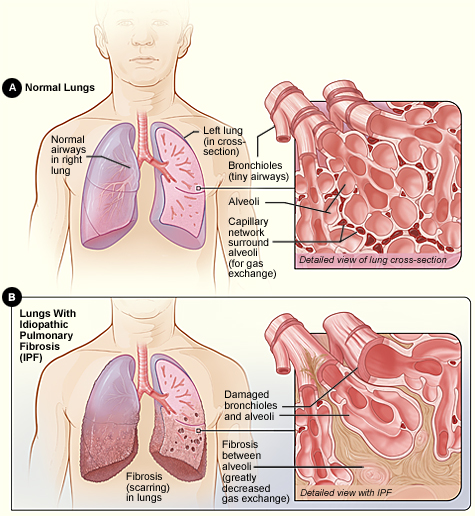


If that happened to you, you would want to know your prognosis. 

That’s where a troubling disease becomes frightening for the patient: outcomes can range from long-term stability to rapid deterioration, but doctors aren’t easily able to tell where an individual may fall on that spectrum. 

We as Data Scientists, should be able to help in predicting this disease, which would dramatically help both patients and clinicians.

Current methods make fibrotic lung diseases difficult to treat, even with access to a chest CT scan. 

In addition, the wide range of varied prognoses create issues organizing clinical trials. 

Finally, patients suffer extreme anxiety—in addition to fibrosis-related symptoms—from the disease’s opaque path of progression.

Open Source Imaging Consortium (OSIC) is a not-for-profit, co-operative effort between academia, industry and philanthropy. 

The group enables rapid advances in the fight against Idiopathic Pulmonary Fibrosis (IPF), fibrosing interstitial lung diseases (ILDs), and other respiratory diseases, including emphysematous conditions. 

Its mission is to bring together radiologists, clinicians and computational scientists from around the world to improve 
imaging-based treatments.

# What we need to do?

In this competition, we need to predict a patient’s severity of decline in lung function based on a CT scan of their lungs. 

We will determine lung function based on output from a spirometer, which measures the volume of air inhaled and exhaled. The challenge is to use machine learning techniques to make a prediction with the image, metadata, and baseline FVC as input.

# DATA

In the dataset,We have a baseline chest CT scan and associated clinical information for a set of patients. A patient has an image acquired at time Week = 0 and has numerous follow up visits over the course of approximately 1-2 years, at which time their FVC is measured.

In the training set, we are provided with an anonymized, baseline CT scan and the entire history of FVC measurements.

In the test set, we are provided with a baseline CT scan and only the initial FVC measurement. We are asked to predict the final three FVC measurements for each patient, as well as a confidence value in your prediction.

Since this is real medical data,relative timing of FVC measurements varies widely. The timing of the initial measurement relative to the CT scan and the duration to the forecasted time points may be different for each patient. This is considered part of the challenge of the competition. To avoid potential leakage in the timing of follow up visits, we are asked to predict every patient's FVC measurement for every possible week. Those weeks which are not in the final three visits are ignored in scoring.

# Evaluation Metrics

This competition is evaluated on a modified version of the Laplace Log Likelihood. 

In medical applications, it is useful to evaluate a model's confidence in its decisions. Accordingly, the metric is designed to reflect both the accuracy and certainty of each prediction.

For each true FVC measurement, we will predict both an FVC and a confidence measure (standard deviation σ). The metric is computed as:

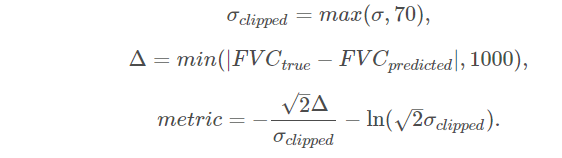


The error is thresholded at 1000 ml to avoid large errors adversely penalizing results, while the confidence values are clipped at 70 ml to reflect the approximate measurement uncertainty in FVC. The final score is calculated by averaging the metric across all test set Patient_Weeks (three per patient). **Note that metric values will be negative and higher is better.**

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight') # For plots
plt.rcParams['figure.figsize'] = (10, 8)
import numpy as np # linear algebra
import os
import glob
import pydicom

# Load datasets

In [ ]:
test = pd.read_csv("/kaggle/input/osic-pulmonary-fibrosis-progression/test.csv")
sub = pd.read_csv("/kaggle/input/osic-pulmonary-fibrosis-progression/sample_submission.csv")
train = pd.read_csv("/kaggle/input/osic-pulmonary-fibrosis-progression/train.csv")
train_dir = "/kaggle/input/osic-pulmonary-fibrosis-progression/train/"
test_dir = "/kaggle/input/osic-pulmonary-fibrosis-progression/test/"

In [ ]:
# lets check dimensions of the train and test datasets
train.shape, test.shape,sub.shape

In [ ]:
# check training data
train.head()

In [ ]:
# check test dataset
test

In [ ]:
# sample submission
sub.head()

In [ ]:
# check for null values
train.isnull().sum()

In [ ]:
# nº of unique patients in the traiing dataset
train.Patient.nunique()

# Lets check how FVC is distributed in the dataset

In [ ]:
# distribution plot for FVC
sns.distplot(train.FVC, hist = False,color = "darkred")
plt.title("FVC Distribution")

FVC ranges from 1000 to somewhere around 5000 mostly, went above 5000 in very few cases

# Let's check the frequency of patients visits for FVC Check

In [ ]:
df =  train.groupby("Patient").count()["Weeks"].value_counts()
df

**Most of the customers got their FVC checked for 9 times**

# Lets check categorical variables "Sex" and "SmokingStatus"

In [ ]:
# lets check the nº of males/females in the dataset
sizes =  [len(train[train.Sex == "Male"]),len(train[train.Sex == "Female"])]
explode = (0.1,0)  # explode 1st slice
colors = ['Green',"Cyan"]
plt.pie(sizes, explode=explode, labels=train.Sex.unique(), colors=colors,autopct='%1.1f%%', shadow=True, startangle=140)
plt.axis('equal')
plt.title("Pie Chart for Gender Distribution")
plt.show()

**Clearly, 79% of the pateints are Males and the rest females**

In [ ]:
# checking smoking status 
train.SmokingStatus.value_counts()

In [ ]:
# lets check smoking distribution
train.SmokingStatus.unique()
sizes =  [len(train[train.SmokingStatus == "Ex-smoker"]),len(train[train.SmokingStatus == "Currently smokes"]),len(train[train.SmokingStatus == "Never smoked"])]
explode = (0,0,0.1)
colors = ['Cyan',"Green","Red"]
plt.pie(sizes, explode=explode, labels=train.SmokingStatus.unique(), colors=colors,autopct='%1.1f%%', shadow=True, startangle=140)

plt.axis('equal')
plt.title("Pie Chart for SmokingStatus Distribution")
plt.show()

**Above pie shows that majority of the customers were into smoking, either they smoke currently or they used to smoke ealier(may be prior to get infected from the disease)**

# Age-Wise Distribution

In [ ]:
train.Age.min(),train.Age.max()

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize = (16, 6))

# Patient age group
ageGroupLabel = 'Below 60', '60-70', '70-80', 'Above 80'

below60 = len(train[train.Age<60])
sixty_to_seventy = len(train[(train['Age']>=60) & (train['Age']<= 70)])
seventy_to_eighty = len(train[(train['Age']>70) & (train['Age']<= 80)])
above80 = len(train[train.Age>80])

# Number of Guests expected in age group
patientNumbers     = [below60, sixty_to_seventy, seventy_to_eighty,above80] 

explode = (0, 0, 0, 0.1)
colors  = ("green","indigo","blue", "red")

# Draw the pie chart
ax1.pie(patientNumbers,explode = explode,colors = colors,labels = ageGroupLabel,autopct = '%1.2f',startangle = 90)

# Aspect ratio
ax1.axis('equal')


# distribution plot for Age
sns.distplot(train.Age, hist = False, color = "indigo")
plt.suptitle("Age Distribution")

plt.show()

**Most of the patients belongs to 60 to 70 age group, very few patients are above 80**

# Week-Wise Distribution

In [ ]:
train.Weeks.min(),train.Weeks.max()

In [ ]:
# Patient age group

below10 = len(train[train.Weeks<10])
eleven_20 = len(train[(train['Weeks']>=11) & (train['Weeks']<= 20)])
twentyone_30 = len(train[(train['Weeks']>20) & (train['Weeks']<= 30)])
thirtyone_40 = len(train[(train['Weeks']>30) & (train['Weeks']<= 40)])
fortyone_50 = len(train[(train['Weeks']>40) & (train['Weeks']<= 50)])
fiftyone_60 = len(train[(train['Weeks']>50) & (train['Weeks']<= 60)])
sixtyone_70 = len(train[(train['Weeks']>60) & (train['Weeks']<= 70)])
seventyone_80 = len(train[(train['Weeks']>70) & (train['Weeks']<= 80)])
eightyone_90 = len(train[(train['Weeks']>80) & (train['Weeks']<= 90)])
ninetyone_100 = len(train[(train['Weeks']>90) & (train['Weeks']<= 100)])
hundredone_110 = len(train[(train['Weeks']>100) & (train['Weeks']<= 110)])
hundredten_120 = len(train[(train['Weeks']>110) & (train['Weeks']<= 120)])
above120 = len(train[train.Weeks>120])

sizes = [below10, eleven_20, twentyone_30, thirtyone_40, fortyone_50, fiftyone_60,sixtyone_70,seventyone_80,eightyone_90,ninetyone_100,hundredone_110,hundredten_120,above120]
labels =  'below10','eleven_20', 'twentyone_30', 'thirtyone_40', 'fortyone_50', 'fiftyone_60','sixtyone_70','seventyone_80','eightyone_90','ninetyone_100','hundredone_110','hundredten_120','above120'


fig1, (ax1, ax2)= plt.subplots(1,2,figsize=(15, 10))

theme = plt.get_cmap('prism')
ax1.set_prop_cycle("color", [theme(1. * i / len(sizes)) for i in range(len(sizes))])

_, _ = ax1.pie(sizes, startangle=90)

ax1.axis('equal')

total = sum(sizes)
ax1.legend(
    loc='upper left',
    labels=['%s, %1.1f%%' % (
        l, (float(s) / total) * 100) for l, s in zip(labels, sizes)],
    prop={'size': 11},
    bbox_to_anchor=(0.0, 1),
    bbox_transform=fig1.transFigure
)

# distribution plot for Weeks
sns.distplot(train.Weeks, hist = False, color = "indigo")
plt.suptitle("Weeks Distribution")

plt.show()

**From the above pie chart we can conclude that almost 50% of the patients got their FVC checked between weeks -5 to 30**

# Pair Plot & Heat Map

In [ ]:
# heat map
corrMatrix = train.corr()
mask = np.triu(corrMatrix)
sns.heatmap(corrMatrix,
            annot=True,
            fmt='.1f',
            cmap='coolwarm',            
            mask=mask,
            linewidths=1,
            cbar=False)
plt.show()

If we look at the overall dataset, FVC and Percent seems to have a decent relationship.

Age and FVC also seems to have inverse correlation

In [ ]:
# Pair plot
sns.pairplot(train)

From the above pair plot , its again very clear that FVC has a strong correlation with Percent. For rest of the features, it either has no relation or it is loosely correlated.

# Lets draw pairplot, will set different colors for different categories of smoking status & sex

In [ ]:
sns.pairplot(train,hue="SmokingStatus")
plt.show()

In [ ]:
sns.pairplot(train,hue="Sex")
plt.show()

# Lets ZOOM-IN (Draw pair plots for the first 3 patients)

In [ ]:
df_0 = train[train.Patient == train.Patient[0]]
sns.pairplot(df_0)
plt.show()

In [ ]:
df_1 = train[train.Patient == train.Patient[1]]
sns.pairplot(df_1)
plt.show()

In [ ]:
df_2 = train[train.Patient == train.Patient[2]]
sns.pairplot(df_2)
plt.show()

**What we saw for the whole dataset is also true for each of the 3 pateints we checked above Pattern is the same, only FVC & Percent seems to have a decent correlation**

# Mean FVC Males Vs Females

In [ ]:
# lets group Male & Female data
grp = train.groupby("Sex")

# draw a plot to display mean of FVC for Males and Females
splot = sns.barplot(x=train.Sex.unique(),y= grp["FVC"].mean())

for p in splot.patches:
    splot.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')

plt.xlabel("Sex",fontsize = 30)
plt.ylabel("Mean FCV",fontsize = 30)
plt.title ("FVC Mean for Male Vs Female",fontsize = 30) 
plt.show()

**Mean FVC is lower for Males, but this can be misleading, as we dont have enough data for female patients**

# Mean FVC for different SmokingStatus

In [ ]:
# lets create groupwise data for different categories of smoking status
grp = train.groupby("SmokingStatus")

# draw a barplot for different smoking categories vs mean FVC for individual categories
splot  = sns.barplot(x=train.SmokingStatus.unique(),y= grp["FVC"].mean())

for p in splot.patches:
    splot.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')

plt.xlabel("Smoking Status",fontsize = 30)
plt.ylabel("Mean FCV",fontsize = 30)
plt.title ("FVC Mean for different Smoking Categories",fontsize = 30) 
plt.show()

Mean FVC is the least for those who currently smoke, best for those who never smoked, makes complete sense. Though we do not have enough data for the non-smokers.

# Mean FVC - Week wise

In [ ]:
plt.figure(figsize=(12,8))
# lets create bins for weeks
train["Weeks_Bins"] = pd.cut(train["Weeks"], 13, duplicates = 'drop') # creating bins     

# group the data for the bins created above
grp = train.groupby("Weeks_Bins")

# draw a barplot for different weeks bins and mean FVC
splot = sns.barplot(x=train.Weeks_Bins.unique(),y= grp["FVC"].mean())
splot.set_xticklabels(splot.get_xticklabels(),rotation = 45)

for p in splot.patches:
    splot.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')

plt.xlabel("Weeks Bins",fontsize = 30)
plt.ylabel("Mean FCV",fontsize = 30)
plt.title ("FVC Mean for different Weeks Bins",fontsize = 30) 
plt.show()

**There is not much variation in FVC for different Weeks**

# Mean FVC - Age wise

In [ ]:
train["Age_Bins"] = pd.cut(train["Age"], 4, duplicates = 'drop') # creating bins     
grp = train.groupby("Age_Bins")
splot = sns.barplot(x=train.Age_Bins.unique(),y= grp["FVC"].mean())
splot.set_xticklabels(splot.get_xticklabels(),rotation = 45)

for p in splot.patches:
    splot.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')

plt.xlabel("Age Bins",fontsize = 30)
plt.ylabel("Mean FCV",fontsize = 30)
plt.title ("FVC Mean for different Age Bins",fontsize = 30) 
plt.show()

**Again, FVC is evenly distribute for all age groups**

# FVC Vs Weeks Plot for Randomly selected patients

In [ ]:
p_id = list(train.Patient.sample(3))
p_id

In [ ]:
# lets draw a plot for a random patient, we will check how its FVC varies as value of Weeks is changed
plt.plot(train[train.Patient == p_id[0]].Weeks,train[train.Patient == p_id[0]].FVC,color = "darkblue")

plt.xlabel("Weeks",fontsize = 30)
plt.ylabel("FCV",fontsize = 30)
title = "FVC for patient:"+ p_id[0]
plt.title (title,fontsize = 25) 
plt.show()

In [ ]:
# lets draw a plot for a random patient, we will check how its FVC varies as value of Weeks is changed
plt.plot(train[train.Patient == p_id[1]].Weeks,train[train.Patient == p_id[1]].FVC, color = "darkgreen")

plt.xlabel("Weeks",fontsize = 30)
plt.ylabel("FCV",fontsize = 30)
title = "FVC for patient:"+ p_id[1]
plt.title (title,fontsize = 25)  
plt.show()

In [ ]:
# lets draw a plot for a random patient, we will check how its FVC varies as value of Weeks is changed
plt.plot(train[train.Patient == p_id[2]].Weeks,train[train.Patient == p_id[2]].FVC,color = "purple")

plt.xlabel("Weeks",fontsize = 30)
plt.ylabel("FCV",fontsize = 30)
title = "FVC for patient:"+ p_id[2]
plt.title (title,fontsize = 25) 
plt.show()

Above plots are giving us better inttutions as far as relation between Weeks and FVC is concerned.
When we zoomed the data to individual patients, mostly, FVC shows decreasing trend as we progress towards higher weeks

# DICOM Files - Introduction

`Digital Imaging and Communications` in Medicine (DICOM) is the standard for the communication and management of medical imaging information and related data.These files may also include patient information to pair the image with the patient.

`DICOM` is most commonly used for storing and transmitting medical images enabling the integration of medical imaging devices such as scanners, servers, workstations, printers, network hardware, and picture archiving and communication systems (PACS) from multiple manufacturers. It has been widely adopted by hospitals and is making inroads into smaller applications like dentists' and doctors' offices.


Multiple .dcm files represent different slices of a single CT scan. CT scans produce 3D volumes for each scan, those volumes consist of 2D slices and each slice is a .dcm file.

We have 2 directories here, `train` and `test`, both these directories have dicom images for different-different patients.

Inside `train` directory, we have sub directories, one sub-directory per patient. Each sub directory containts dicom files for that particular patient.

# Let's check what's present in train directory

In [ ]:
# review training directory
p_sizes = [] # list of no. of dcm files present for each patientx

for d in os.listdir(train_dir):
    print("Patient '{}' has {} scans".format(d, len(os.listdir(train_dir + d))))
    p_sizes.append(len(os.listdir(train_dir + d)))

print('----')
print('Total patients {} Total DCM files {}'.format(len(os.listdir(train_dir)), 
                                                      len(glob.glob(train_dir+ "/*/*.dcm"))))

**We have total 176 directories (1 directory per patient) and total of 33026 dicom images**

In [ ]:
# lets visualize trainig data
p = sns.color_palette()
plt.hist(p_sizes, color=p[2])
plt.ylabel('Number of patients')
plt.xlabel('Count of DICOM files')
plt.title('Histogram of DICOM count per patient - Training Data')

We can see that the train directory is made up of a bunch of subdirectories, each representing a single patient ID and containing about 20-600 DICOM files inside, there are few patients between 800 to 1000 dicom files, seems to be outliars.

In [ ]:
# review test directory
p_sizes = [] # list of no. of dcm files present for each patientx

for d in os.listdir(test_dir):
    print("Patient '{}' has {} scans".format(d, len(os.listdir(test_dir + d))))
    p_sizes.append(len(os.listdir(test_dir + d)))

print('----')
print('Total patients {} Total DCM files {}'.format(len(os.listdir(test_dir)), 
                                                      len(glob.glob(test_dir+ "/*/*.dcm"))))

**Test directory has data for 5 patients, and a total of 1261 images**

In [ ]:
# lets visualize image distribution per patient
plt.hist(p_sizes, color=p[3])
plt.ylabel('Number of patients')
plt.xlabel('Count of DICOM files')
plt.title('Histogram of DICOM count per patient - Test Data')

Test directory has around 28 to 400 images per patient

# Let's check the size of the dicom images

In [ ]:
sizes = [os.path.getsize(dcm)/1000000 for dcm in glob.glob(train_dir+ "/*/*.dcm")]
print('DCM file sizes: min {:.3}MB max {:.3}MB avg {:.3}MB std {:.3}MB'.format(np.min(sizes), 
                                                       np.max(sizes), np.mean(sizes), np.std(sizes)))

We can see here that basically all the DICOM files are somewhere between 2.7 to 3.4 MB.

# Lets load a random dicom image

DICOM files can be read and processed easily with pydicom package. DICOM files allow to store metadata along with pixel data inside them. Reading a dicom file creates a pydicom.dataset.FileDataset object. FileDataset object wraps dict and contains DataElement instances.

In [ ]:
# read a dcm file for patient ID00368637202296470751086
dcm = '/kaggle/input/osic-pulmonary-fibrosis-progression/train/ID00368637202296470751086/270.dcm'
print('Filename: {}'.format(dcm))
dcm = pydicom.read_file(dcm)

Now, we have read the image in a variable called dcm, we can simply "print" this variable to see the information related to the image

In [ ]:
print(dcm)

There are two things here that I think are significant, slice location and the 'Pixel Data'.

We can retrieve a image as a numpy array by calling dcm.pixel_array, and we can then replace the -2000s, which are essentially NAs, with 0s.

In [ ]:
# display the image read above
img = dcm.pixel_array
img[img == -2000] = 0

plt.axis('off')
plt.imshow(img)
plt.show()

plt.axis('off')
plt.imshow(-img) # Invert colors with -
plt.show()

# Lets plot some more images at random

In [ ]:
# helper function
def dicom_to_image(filename):
    dcm = pydicom.read_file(filename)
    img = dcm.pixel_array
    img[img == -2000] = 0
    return img

In [ ]:
# lets display some 20 images at random
files = glob.glob(train_dir + "/*/*.dcm")

f, plots = plt.subplots(4, 5, sharex='col', sharey='row', figsize=(10, 8))
for i in range(20):
    plots[i // 5, i % 5].axis('off')
    plots[i // 5, i % 5].imshow(dicom_to_image(np.random.choice(files)), cmap=plt.cm.bone)

This gives us some idea with the sort of images we're dealing with. Now, let's try to reconstruct the layers of the body from which the images were taken, by taking a single patient and sorting his scans by Slice Location.

In [ ]:
# function to sort patients dcm images
def get_slice_location(dcm):
    return float(dcm[0x0020, 0x1041].value)

# Returns a list of images for that patient_id, in ascending order of Slice Location
def load_patient(patient_id):
    files = glob.glob(train_dir + patient_id + "/*.dcm")
    imgs = {}
    for f in files:
        dcm = pydicom.read_file(f)
        img = dcm.pixel_array
        img[img == -2000] = 0
        sl = get_slice_location(dcm)
        imgs[sl] = img
        
    # Not a very elegant way to do this
    sorted_imgs = [x[1] for x in sorted(imgs.items(), key=lambda x: x[0])]
    return sorted_imgs


Now that we have the images of a patient sorted by position in the body, we can plot them to see how this varies.

In [ ]:
# display  all dcm images for patient ID00210637202257228694086
pat = load_patient('ID00210637202257228694086')
f, plots = plt.subplots(31, 10, sharex='all', sharey='all', figsize=(10, 31))
for i in range(303):
    plots[i // 10, i % 10].axis('off')
    plots[i // 10, i % 10].imshow(pat[i], cmap=plt.cm.bone)

In [ ]:
# display  all dcm images for patient ID00368637202296470751086
pat = load_patient('ID00368637202296470751086')
f, plots = plt.subplots(35, 10, sharex='all', sharey='all', figsize=(10, 35))
for i in range(341):
    plots[i // 10, i % 10].axis('off')
    plots[i // 10, i % 10].imshow(pat[i], cmap=plt.cm.bone)

In [ ]:
# display  all dcm images for patient ID00169637202238024117706
pat = load_patient('ID00169637202238024117706')
f, plots = plt.subplots(12, 10, sharex='all', sharey='all', figsize=(10, 12))
for i in range(115): 
    plots[i // 10, i % 10].axis('off')
    plots[i // 10, i % 10].imshow(pat[i], cmap=plt.cm.bone)

We can actually use this to reconstruct a 3D model of the of the torso by simply concatenating the images together. Then something like a 3D convolutional network could be applied on top in order to identify points of interest in 3D space. Interesting stuff.

# Let's stack up all the dicom images of a patient to create a 3D volume

In [ ]:
import matplotlib.animation as animation
from IPython.display import HTML

In [ ]:
# stack up all the 2D slices to make up a 3D volume
def load_scan(patient_name):
    
    patient_directory = sorted(os.listdir(f'../input/osic-pulmonary-fibrosis-progression/train/{patient_name}'), key=(lambda f: int(f.split('.')[0])))
    volume = np.zeros((len(patient_directory), 512, 512))

    for i, img in enumerate(patient_directory):
        img_slice = pydicom.dcmread(f'../input/osic-pulmonary-fibrosis-progression/train/{patient_name}/{img}')
        volume[i] = img_slice.pixel_array
            
    return volume

In [ ]:
patient_scan = load_scan('ID00368637202296470751086')

In [ ]:
%%capture
fig = plt.figure(figsize=(8, 8))

imgs = []
for ps in patient_scan:
    img = plt.imshow(ps, animated=True, cmap=plt.cm.bone)
    plt.axis('off')
    imgs.append([img])

In [ ]:
vid = animation.ArtistAnimation(fig, imgs, interval=25, blit=False, repeat_delay=1000)

In [ ]:
# lets play the video 
HTML(vid.to_html5_video())